Dieses Notebook untersucht auf Basis umfangreicher Kraftstoffpreisdaten die Frage, wann und wo man am günstigsten tanken kann, und kombiniert dafür explorative Datenanalyse mit zeitlicher, geografischer und anbieterbezogener Auswertung.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar

In [49]:
df = pd.read_csv('Loading/df_PreiseStationen.csv')

/var/folders/_9/fyqnr96j0q7_tlytmj22wy8c0000gn/T/ipykernel_83834/2192871920.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Loading/df_PreiseStationen.csv')


## Erster Überblick

In [50]:
df.head()

,Unnamed: 0,station_uuid,hour,diesel,e5,e10,dieselchange,e5change,e10change,brand,...,name,post_code,latitude,longitude,first_active,openingtimes_json,date,weekday,start_time,end_time
0,0,005056ba-7cb6-1ed2-bceb-519b93268d12,23:00:00,1.699,1.769,1.709,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2023-12-31,Sunday,08:00,23:00
1,1,005056ba-7cb6-1ed2-bceb-519b93268d12,05:00:00,1.769,1.849,1.789,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
2,2,005056ba-7cb6-1ed2-bceb-519b93268d12,06:00:00,1.759,1.839,1.779,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
3,3,005056ba-7cb6-1ed2-bceb-519b93268d12,07:00:00,1.734,1.794,1.734,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
4,4,005056ba-7cb6-1ed2-bceb-519b93268d12,08:00:00,1.744,1.804,1.744,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00


In [51]:
print(df.count())

Unnamed: 0           73589
station_uuid         73589
hour                 73589
diesel               73589
e5                   73589
e10                  73589
dieselchange         73589
e5change             73589
e10change            73589
brand                68097
city                 73589
street               73589
house_number         67120
name                 73589
post_code            73589
latitude             73589
longitude            73589
first_active         73589
openingtimes_json    73589
date                 73589
weekday              73589
start_time           43512
end_time             43512
dtype: int64


Auffälligkeiten:
- Es gibt 73589 Zeilen in dem Datensatz.
- 'brand' hat fehlende Werte (5497 fehlende Werte).
- 'house_number' hat fehlende Werte (6469 fehlende Werte).
- 'start_time' und 'end_time' haben fehlende Werte, beide gleich viele (30077 fehlende Werte).

## Detailliertere Betrachtung einzelner Merkmale

### Marke

 Die Tankstelle ['fa7e7b54-d16f-437d-b7de-c39f75a7e4f9'] hat keine Marke


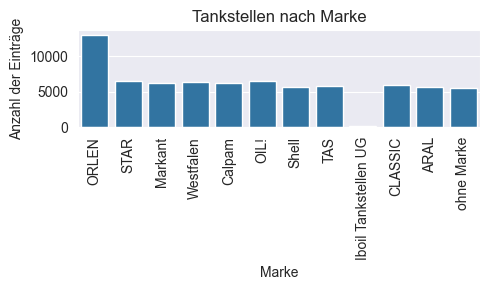

In [52]:
df_brand = df.copy()
print(f' Die Tankstelle {df[df['brand'].isna()]['station_uuid'].unique()} hat keine Marke')
df_brand['brand'] = df_brand['brand'].fillna('ohne Marke')
plt.figure(figsize=(5, 3))
sns.countplot(data=df_brand, x=df_brand['brand'])

plt.title('Tankstellen nach Marke')
plt.xticks(rotation=90)
plt.xlabel('Marke')
plt.ylabel('Anzahl der Einträge')
plt.tight_layout()
plt.show()

### Hausnummer

In [53]:
print(f' Die Tankstelle {df[df['house_number'].isna()]['station_uuid'].unique()} hat keine Hausnummer')
print(df[df['house_number'].isin(['8'])]['station_uuid'].unique())
print(df[df['house_number'].isin([8.0])]['station_uuid'].unique())

print(df[df['house_number'].isin(['26'])]['station_uuid'].unique())
print(df[df['house_number'].isin([26.0])]['station_uuid'].unique())

 Die Tankstelle ['4c746120-5b7d-40ca-8c75-ccd55c4d0814'] hat keine Hausnummer
['2dbf6b64-a83d-4630-ad83-c16015b8efa4']
['2dbf6b64-a83d-4630-ad83-c16015b8efa4']
['e353671a-b0bc-4fd4-bbf0-7d29cfcb2489']
['e353671a-b0bc-4fd4-bbf0-7d29cfcb2489']


In [54]:
df['house_number'].unique()

array(['102', '52', '156a', '36', '55', '8', 8.0, nan, 57.0, 81.0, 82.0,
       11.0, 26.0, '26', '79a'], dtype=object)

Auffälligkeiten:
- Die Hausnummern liegen in unterschiedlichen Formaten vor.
- Bei der Tankstelle '2dbf6b64-a83d-4630-ad83-c16015b8efa4' liegen die Hausnummern in zwei verschiedenen Formaten vor.
    - Sie haben allerdings die gleiche uuid.
- Dasselbe bei der Tankstelle 'e353671a-b0bc-4fd4-bbf0-7d29cfcb2489'.

Anpassung: Die Hausnummern werden auf ein einheitliches Format gebracht und fehlende Werte ergänzt.

In [55]:
def clean_house_number(val):
    if isinstance(val, str) and val.replace('.', '').isdigit():
        return str(int(float(val)))
    return None
df['house_number'] = df['house_number'].astype(str).apply(clean_house_number)
df['street'] = df['street'].str.replace(r'\s*\d+[a-zA-Z]?\s*$', '', regex=True)
df['house_number'] = df['house_number'].fillna('22')

### Öffnungszeiten

In [56]:
df

,Unnamed: 0,station_uuid,hour,diesel,e5,e10,dieselchange,e5change,e10change,brand,...,name,post_code,latitude,longitude,first_active,openingtimes_json,date,weekday,start_time,end_time
0,0,005056ba-7cb6-1ed2-bceb-519b93268d12,23:00:00,1.699,1.769,1.709,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2023-12-31,Sunday,08:00,23:00
1,1,005056ba-7cb6-1ed2-bceb-519b93268d12,05:00:00,1.769,1.849,1.789,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
2,2,005056ba-7cb6-1ed2-bceb-519b93268d12,06:00:00,1.759,1.839,1.779,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
3,3,005056ba-7cb6-1ed2-bceb-519b93268d12,07:00:00,1.734,1.794,1.734,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
4,4,005056ba-7cb6-1ed2-bceb-519b93268d12,08:00:00,1.744,1.804,1.744,1.0,1.0,1.0,ORLEN,...,ORLEN Tankstelle,32427,52.288749,8.898652,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-01-01,Monday,06:00,23:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73584,73584,fa7e7b54-d16f-437d-b7de-c39f75a7e4f9,15:00:00,1.589,1.709,1.649,1.0,1.0,1.0,NaN,...,Tankstelle Harting Minden,32423,52.294837,8.934219,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-12-31,Tuesday,06:30,19:30
73585,73585,fa7e7b54-d16f-437d-b7de-c39f75a7e4f9,16:00:00,1.559,1.679,1.619,1.0,1.0,1.0,NaN,...,Tankstelle Harting Minden,32423,52.294837,8.934219,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-12-31,Tuesday,06:30,19:30
73586,73586,fa7e7b54-d16f-437d-b7de-c39f75a7e4f9,17:00:00,1.574,1.694,1.634,1.0,1.0,1.0,NaN,...,Tankstelle Harting Minden,32423,52.294837,8.934219,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-12-31,Tuesday,06:30,19:30
73587,73587,fa7e7b54-d16f-437d-b7de-c39f75a7e4f9,19:00:00,1.584,1.704,1.644,1.0,1.0,1.0,NaN,...,Tankstelle Harting Minden,32423,52.294837,8.934219,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period...",2024-12-31,Tuesday,06:30,19:30


In [57]:
df_startNan = df.copy()
df_startNan = df_startNan[df_startNan['start_time'].isna()]
df_startNan['start_time'].unique()

array([nan], dtype=object)

In [58]:
df_startNan
print(df_startNan['station_uuid'].unique())
print(df_startNan['openingtimes_json'].unique())

['2dbf6b64-a83d-4630-ad83-c16015b8efa4'
 '4c746120-5b7d-40ca-8c75-ccd55c4d0814'
 '831a250e-5810-4bee-bf20-8acd0b60d205'
 'bb8faad1-958c-473a-c9b9-d2a3e4eef30d'
 'c8e68ec5-8eac-11e9-83b5-005056a2a083'
 'e353671a-b0bc-4fd4-bbf0-7d29cfcb2489']
['{}']


In [59]:
df_startNan = df.copy()
df_startNan = df_startNan[df_startNan['start_time'].isna()]
print(f"Bei diesen Tankstellen sind keine Öffnungszieten vorhanden {df_startNan['station_uuid'].unique()}. Auch daran zu erkennen, dass die OpeningTimes-JSON leer sind {df_startNan['openingtimes_json'].unique()}. ")

Bei diesen Tankstellen sind keine Öffnungszieten vorhanden ['2dbf6b64-a83d-4630-ad83-c16015b8efa4'
 '4c746120-5b7d-40ca-8c75-ccd55c4d0814'
 '831a250e-5810-4bee-bf20-8acd0b60d205'
 'bb8faad1-958c-473a-c9b9-d2a3e4eef30d'
 'c8e68ec5-8eac-11e9-83b5-005056a2a083'
 'e353671a-b0bc-4fd4-bbf0-7d29cfcb2489']. Auch daran zu erkennen, dass die OpeningTimes-JSON leer sind ['{}']. 


In [60]:
tankstellen = df_startNan['name'].unique()
for tankstelle in tankstellen:
    print(f'{tankstelle} hat insgesamt {len(df_startNan[df_startNan['name'] == tankstelle]['hour'].unique())} Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um {df_startNan[df_startNan['name'] == tankstelle]['hour'].unique().min()} und die letzte um {df_startNan[df_startNan['name'] == tankstelle]['hour'].unique().max()}.')

Calpam Tankstelle hat insgesamt 24 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 00:00:00 und die letzte um 23:00:00.
OIL! Tankstelle Minden hat insgesamt 21 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 03:00:00 und die letzte um 23:00:00.
Shell Minden Stiftstr. 57 hat insgesamt 20 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 00:00:00 und die letzte um 22:00:00.
Iboil Minden hat insgesamt 19 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 04:00:00 und die letzte um 22:00:00.
CLASSIC Minden(CLASSIC) hat insgesamt 22 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 00:00:00 und die letzte um 23:00:00.
Aral Tankstelle hat insgesamt 19 Stunden am Tag Werte übermittelt. Dabei ist der früheste Übermittlung um 03:00:00 und die letzte um 21:00:00.


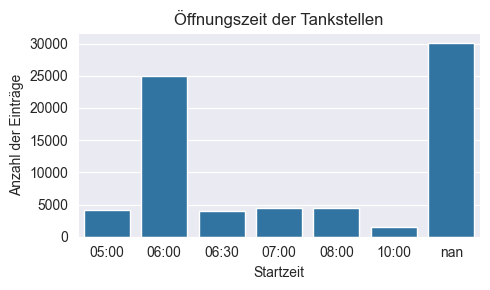

In [61]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x=df['start_time'].astype(str).fillna('Unbekannt'), order=sorted(df['start_time'].astype(str).unique()))

plt.title('Öffnungszeit der Tankstellen')
plt.ylabel('Anzahl der Einträge')
plt.xlabel('Startzeit')
plt.tight_layout()
plt.show()

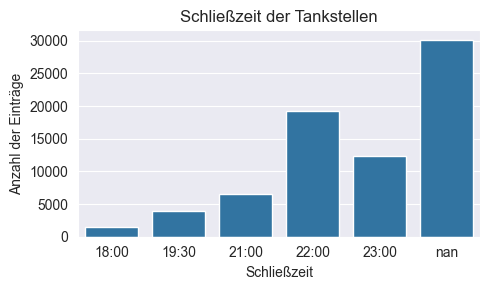

In [62]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x=df['end_time'].astype(str).fillna('Unbekannt'), order=sorted(df['end_time'].astype(str).unique()))

plt.title('Schließzeit der Tankstellen')
plt.xlabel('Schließzeit')
plt.ylabel('Anzahl der Einträge')
plt.tight_layout()
plt.show()

In [63]:
df_time = df.copy()
df_time['hour'] = pd.to_datetime(df_time['hour'], format='%H:%M:%S').dt.time
df_time['start_time'] = pd.to_datetime(df_time['start_time'], format='%H:%M').dt.time
df_time['end_time'] = pd.to_datetime(df_time['end_time'], format='%H:%M').dt.time
außerhalb_zeiten = df_time[
    (df_time['hour'] < df_time['start_time']) | (df_time['hour'] > df_time['end_time'])
]
print(f'Bei den Tankstellen {außerhalb_zeiten['station_uuid'].unique()} wurden Preisänderungen außerhalb der angegebenen Öffnungszeiten vorgenommen.')

Bei den Tankstellen ['005056ba-7cb6-1ed2-bceb-519b93268d12'
 '005056ba-7cb6-1ed2-bceb-568a4bb56d15'
 '005056ba-7cb6-1ed2-bceb-842a27f12d2e'
 '22c0f242-2209-4b43-b544-26e2b5a2463c'
 '2966f3e3-e45f-4439-ba49-1c0c481f5f3d'
 'bad559b9-cabe-4589-bafb-5547683b6562'
 'fa7e7b54-d16f-437d-b7de-c39f75a7e4f9'] wurden Preisänderungen außerhalb der angegebenen Öffnungszeiten vorgenommen.


Auffälligkeiten:
- Wenn eine Tankstelle keine start_time hat, dann hat sie auch keine end_time.
- Es haben 6 Tankstellen keine start_time.
- Wenn openingtimes_json = {} ist, dann fehlt die start_time.
- Wenn die Tankstellen keine start-time haben, dann werden teilweise 24 Stunden lang Werte übermittelt.
    - Nach Abgleich mit Informationen aus dem Internet sind diese Tankstellen rund um die Uhr geöffnet.
- In den Plots ist zu erkennen, dass die meisten Tankstellen, von denen die Öffnungszeiten bekannt sind um 6 Uhr öffnen und um 22 Uhr schließen.

Anpassungen: Bei Tankstellen ohne Öffnungszeiten konnte ermittelt werden, dass diese 24-Stunden geöffnet haben. Die Öffnungszeiten werden manuell nachgetragen.

In [64]:
df['start_time'] = df['start_time'].fillna('00:00')
df['end_time'] = df['end_time'].fillna('23:59')

### Street

In [65]:
len(df['street'].unique())
df['street'].unique()

array(['Königstraße', 'Portastraße', 'Marienstraße', 'Stiftsallee',
       'Lübbecker Str.', 'Kutenhauser Dorfstr.', 'Viktoriastraße',
       'Stiftstr.', 'Ringstrasse', 'Friedrich-Wilhelm-Str.',
       'Ringstraße ', 'Friedrich-Wilhelm-Str. '], dtype=object)

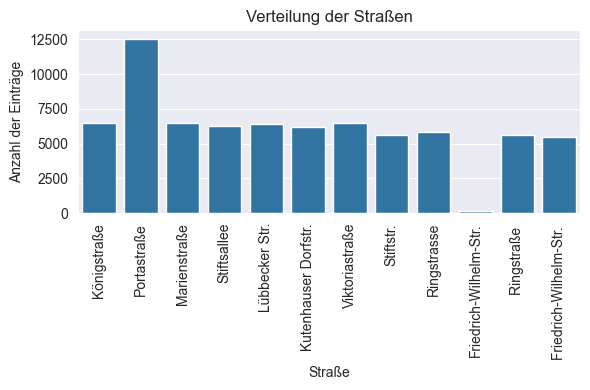

In [66]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=df['street'])

plt.title('Verteilung der Straßen')
plt.xticks(rotation=90)
plt.ylabel('Anzahl der Einträge')
plt.xlabel('Straße')
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Es gibt 12 Straßen in dem Datensatz. Zwei Straßen sind doppelt in den Daten enthalten, jeweils mit unterschiedlichen Schreibweisen:
    - Ringstraße und Ringstrasse,
    - Friedrich-Wilhelm-Str. und Friedrich-Wilhelm-Str. (zweiter Wert hat ein Leerzeichen am Ende) und
    - Viktoriastraße hat noch eine Hausnummer in den Daten.
- In dem Plot ist zu erkennen, dass die meisten Eintränge von der Portastraße kommen. Wenn man allerdings beachtet, dass die Ringstraße in unterschiedlichen Schreibweisen auftaucht, wäre hier ähnlich viele Werte wie bei der Portastraße.

Anpassungen: Die Schreibweisen der Straßen werden aneinander angepasst.

In [67]:
df['street'] = df['street'].str.replace(r'strasse', 'straße', regex=True)
df['street'] = df['street'].str.replace(r'Str.', 'Straße', regex=True)
df['street'] = df['street'].str.replace(r'Dorfstr.', 'Dorfstraße', regex=True)
df['street'] = df['street'].str.replace(r'Stiftstr.', 'Stiftstraße', regex=True)
df['street'] = df['street'].str.replace(r'aße ', 'aße', regex=True)

## Kraftstoffe

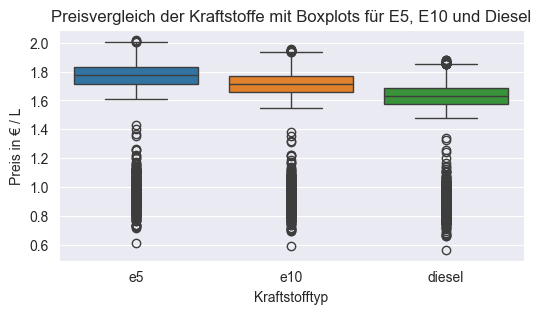

In [68]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df[['e5', 'e10', 'diesel']])
plt.title('Preisvergleich der Kraftstoffe mit Boxplots für E5, E10 und Diesel')
plt.ylabel('Preis in € / L')
plt.xlabel('Kraftstofftyp')
plt.show()
plt.tight_layout()
plt.close()

Auffälligkeiten
- In dem Plot ist zu erkennen, dass alle Kraftstoffe Ausreißer nach oben und unten haben.
    - Die unteren Ausreißer sind weiter gestreut.
    - Die oberen Ausreißer sind nahe dem oberen Quantil.
- Die Kraftstoffe haben ähnlich symmetrische Preisverteilungen.
    - Die Streuungen sind ähnlich verteilt.
- Der Mittelwert von E5 ist am höchsten, dann E10 und am geringsten ist der Mittelwert von Diesel.

### E5

In [69]:
print(df['e5'].describe())
print(df['e5'].count()- (df[df['e5'] > 1.0])['e5'].count())

count    73589.000000
mean         1.768951
std          0.097200
min          0.609667
25%          1.714000
50%          1.774000
75%          1.829000
max          2.016500
Name: e5, dtype: float64
308


In [70]:
print(f'Die Tankstelle {df[df['e5'] < 1.0]['station_uuid'].unique()} hat E5 unter 1 €. ')
print(f'An {len(df[df['e5'] < 1.0]['date'].unique())} Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am {df[df['e5'] < 1.0]['date'].unique().min()} und zum letzten mal am {df[df['e5'] < 1.0]['date'].unique().max()}')

Die Tankstelle ['2dbf6b64-a83d-4630-ad83-c16015b8efa4'] hat E5 unter 1 €. 
An 21 Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am 2024-01-20 und zum letzten mal am 2024-04-03


Auffälligkeiten
- E5 hat keine fehlenden Werte.
- Mittelwert liegt bei 1,7690 €.
- Standardabweichung ist 0,0972 €, also liegt eine geringe Streuung vor.
- Preise liegen zwischen 1,71 € und 1,83 €.

### E10

In [71]:
print(df['e10'].describe())
print(df['e10'].count()- (df[df['e10'] > 1.0])['e10'].count())

count    73589.000000
mean         1.711247
std          0.096017
min          0.589667
25%          1.659000
50%          1.715667
75%          1.769000
max          1.956500
Name: e10, dtype: float64
353


In [72]:
print(f'Die Tankstelle {df[df['e10'] < 1.0]['station_uuid'].unique()} hat E10 unter 1 €. ')
print(f'An {len(df[df['e10'] < 1.0]['date'].unique())} Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am {df[df['e10'] < 1.0]['date'].unique().min()} und zum letzten mal am {df[df['e10'] < 1.0]['date'].unique().max()}')

Die Tankstelle ['2dbf6b64-a83d-4630-ad83-c16015b8efa4'] hat E10 unter 1 €. 
An 21 Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am 2024-01-20 und zum letzten mal am 2024-04-03


Auffälligkeiten:
- E10 hat keine fehlenden Werte.
- Mittelwert liegt bei 1,71 €.
- Standardabweichung ist 0,096 €, also lirgt eine geringe Streuung vor.
- Preise liegen zwischen 1,66 € und 1,77 €.

### Diesel

In [73]:
print(df['diesel'].describe())
print(df['diesel'].count()- (df[df['diesel'] > 1.0])['diesel'].count())

count    73589.000000
mean         1.628707
std          0.092175
min          0.563000
25%          1.574000
50%          1.629000
75%          1.684000
max          1.881500
Name: diesel, dtype: float64
379


In [74]:
print(f'Die Tankstelle {df[df['diesel'] < 1.0]['station_uuid'].unique()} hat Dieselpreise unter 1 €. ')
print(f'An {len(df[df['diesel'] < 1.0]['date'].unique())} Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am {df[df['diesel'] < 1.0]['date'].unique().min()} und zum letzten mal am {df[df['diesel'] < 1.0]['date'].unique().max()}')

Die Tankstelle ['2dbf6b64-a83d-4630-ad83-c16015b8efa4'] hat Dieselpreise unter 1 €. 
An 21 Tagen kommt es zu Preisen unter 1 €. Zum erstenmal am 2024-01-20 und zum letzten mal am 2024-04-03


Auffälligkeiten
- Diesel hat keine fehlenden Werte.
- Mittelwert ist bei 1,6287 €.
- Standardabweichung ist 0,0922 €, also liegt eine geringe Streuung vor.
- Die meisten Preise liegen zwischen 1,57 € und 1,68 €.
- Es gibt 379 Werte, bei denen der Dieselpreis unter 1 € liegt.
    - Werte unter 1 € kommen von einer Tankstelle: 2dbf6b64-a83d-4630-ad83-c16015b8efa4.
- Bei Ausschluss der Ausreißer:
    - Mittelwert liegt bei 1,6327 €.
    - Standardabweichung ist 0,074 €.
    - Die meisten Preise liegen zwischen 1,57 € und 1,69 €.

## Ausreißer
Wie in der bisherigen Analyse zu sehen, sind in diesem Datensatz Ausreißer vorhanden. Unter anderem gibt es Werte unter 1 € je Kraftstoff, was unrealistisch niedrig ist. Die folgende Betrachtung ist in zwei Abschnitte unterteilt, bei der einen wird keine Ausreißerbehandlung durchgeführt, bei der anderen schon. Diese doppelte Betrachtung ist insbesondere dann interessant, wenn der Datensatz als Grundlage dient, um die EDA-Fähigkeiten von Sprachmodellen zu bewerten.
Ohne Ausreißerbehandlung lässt sich nachvollziehen, ob ein Modell in der Lage ist, solche extremen und offensichtlich fehlerhaften Werte eigenständig zu erkennen und kritisch einzuordnen.
Mit Ausreißerbehandlung hingegen kann überprüft werden, ob das Modell nach der Datenbereinigung korrekte und unverzerrte statistische Kennzahlen berechnet und die daraus abgeleiteten Muster zuverlässig interpretiert.
Durch den direkten Vergleich beider Szenarien wird sichtbar, ob das Modell nicht nur „deskriptiv beschreibt“, sondern auch Datenqualität aktiv berücksichtigt und den Einfluss von Ausreißern auf Analyseergebnisse versteht.

### Betrachtung ohne Ausreißerbereinigung

## Kraftstoff vs. Zeit

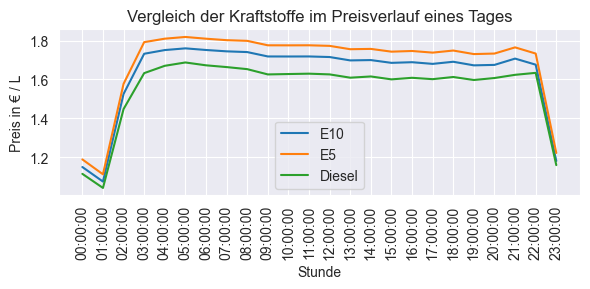

In [75]:
plt.figure(figsize=(6, 3))

sns.lineplot(x='hour', y='e10', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E10')
sns.lineplot(x='hour', y='e5', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E5')
sns.lineplot(x='hour', y='diesel', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='Diesel')

plt.title('Vergleich der Kraftstoffe im Preisverlauf eines Tages')
plt.xlabel('Stunde')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Die Preise sind um Mitternacht am niedrigsten, dies entspricht nicht der Realität.
- Da die meisten Tankstellen um Mitternacht schließen, werden hier keine Daten übermittelt, die die Ergebnisse dann verzerren.
- Über den Tag kann man sehen, dass es früh am morgen, gegen 3 bis 4 Uhr etwas teurer ist.
- Gegen Nachmittag verringern sich die Preise minimal.
- Am Abend gegen 21 bis 22 Uhr steigen die Preise erneut.

## Kraftstoff vs. Weekday

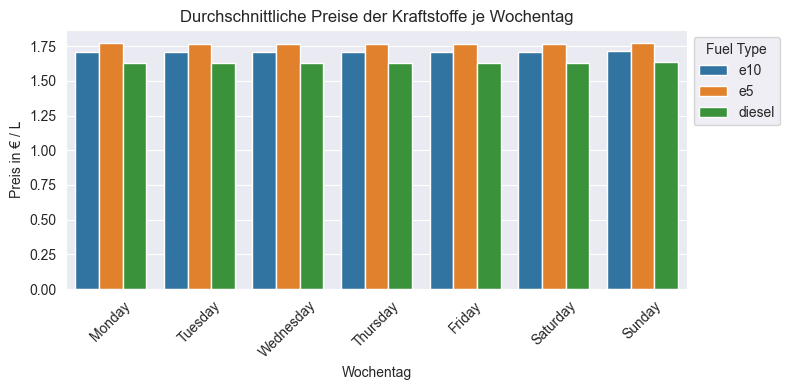

In [76]:
weekday_avg = df.groupby('weekday', observed=False)[['e10', 'e5', 'diesel']].mean().reset_index()
weekday_long = weekday_avg.melt(id_vars='weekday', value_vars=['e10', 'e5', 'diesel'], var_name='Fuel', value_name='Price')
weekday_long['weekday'] = pd.Categorical(weekday_long['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

plt.figure(figsize=(8, 4))
sns.barplot(data=weekday_long, x='weekday', y='Price', hue='Fuel')
plt.title('Durchschnittliche Preise der Kraftstoffe je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=45)
plt.legend(title='Fuel Type', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Auffälligkeiten:
- An jedem Tag ist e5 der teuerste Kraftstoff, gefolgt von E10.
- Diesel ist immer der günstigste Kraftstoff.
- Ein deutlicher Unterschied ist in der Abbildung nicht klar zu erkennen.

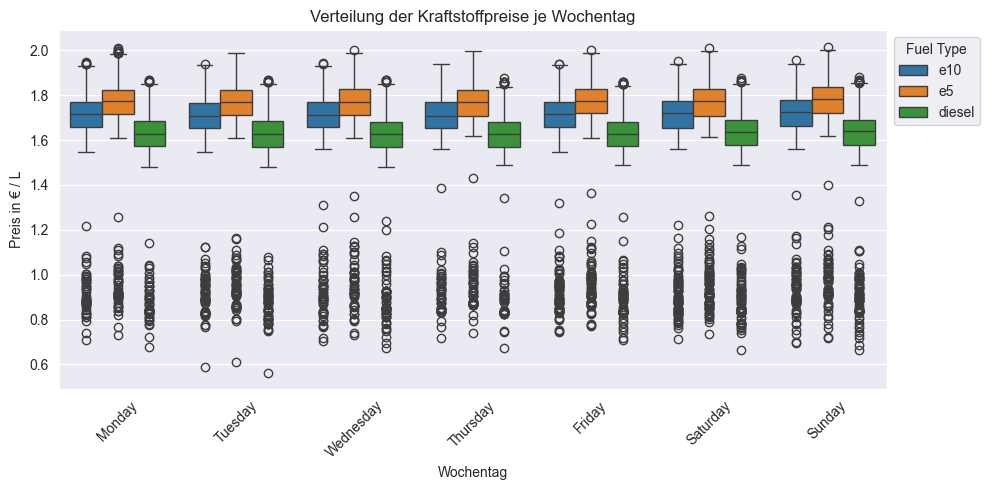

In [77]:
weekday_long = df.melt(id_vars='weekday',value_vars=['e10', 'e5', 'diesel'],var_name='Fuel',value_name='Price')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_long['weekday'] = pd.Categorical(weekday_long['weekday'], categories=weekday_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.boxplot(data=weekday_long, x='weekday', y='Price', hue='Fuel')
plt.title('Verteilung der Kraftstoffpreise je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=45)
plt.legend(title='Fuel Type', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Die unteren Ausreißer bilden Cluster.
- Es gibt am Dienstag die am wenigsten verteilten Ausreißer.
- Diesel hat am jedem Tag auch Ausreißer nach oben.
- Die anderen Kraftstoffe haben auch Ausreißer nach oben, allerdings nicht zu jedem Tag.
- Über die Woche sind keine Unterschiede in der Verteilung zu erkennen, bei den jeweiligen Kraftstoffen.

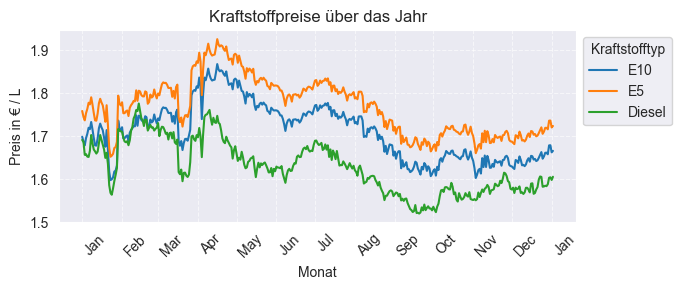

In [78]:
plt.figure(figsize=(6, 3))

sns.lineplot(x='date', y='e10', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E10')
sns.lineplot(x='date', y='e5', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E5')
sns.lineplot(x='date', y='diesel', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='Diesel')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45, ha='left')
plt.title('Kraftstoffpreise über das Jahr')
plt.xlabel('Monat')
plt.ylabel('Preis in € / L')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Kraftstofftyp', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Es ist zu erkennen, dass die Kraftstoffe im Februar und April Ausreißer nach unten haben.
- Alle drei Kraftstoffarten steigen im Zeitraum Februar bis Mai.
    - E5 erreicht in dieser Phase einen Wert von über 1,90 €.
- Ab etwa Juni/Juli sinken alle Preise gleichmäßig.
    - Tiefpunkt bei Diesel ist im Oktober/November, bei ca. 1,50 €.
- Danach eine leichte Steigerung gegen Jahresende.

## Kraftstoff vs. Marke

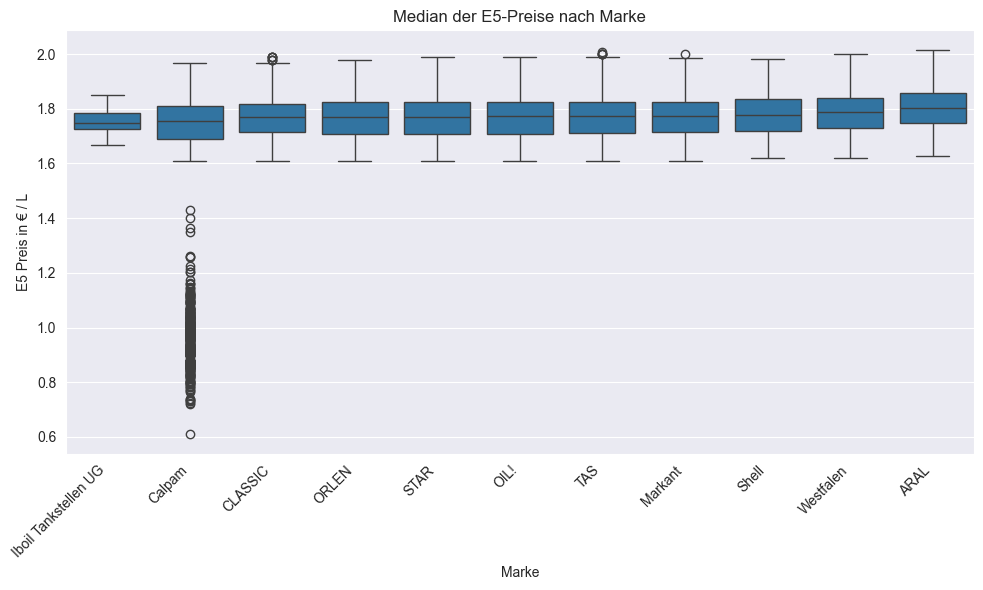

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='brand', y='e5', order=df.groupby('brand')['e5'].median().sort_values().index)

plt.title('Median der E5-Preise nach Marke')
plt.xlabel('Marke')
plt.ylabel('E5 Preis in € / L')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Calpam zeigt eine starke Streuung nach unten:
    - Viele Ausreißer liegen bei unter 1,40 €, einige sogar bei unter 1,00 €, bis hinunter zu ca. 0,60 €.
    - Die Box selbst liegt im normalen Bereich (etwa 1,75 €), aber die vielen Ausreißer verzerren die Interpretation.
- Der Medianpreis liegt bei fast allen Marken zwischen 1,75 € und 1,80 €.
- Die Boxen sind ähnlich breit.
- Es gibt wenige echte Ausreißer bei CLASSIC, TAS, Markant.

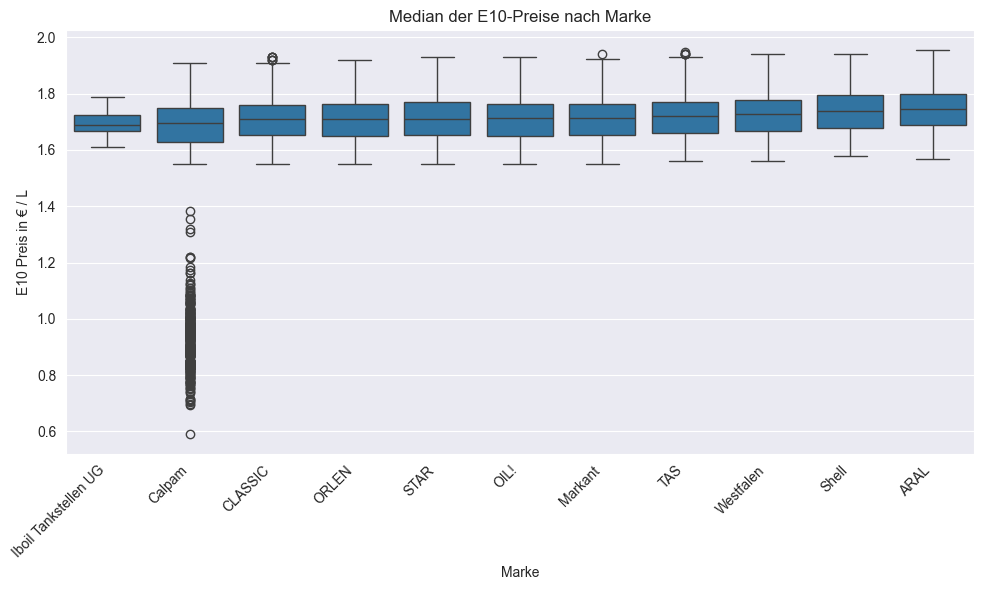

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='brand', y='e10',order=df.groupby('brand')['e10'].median().sort_values().index)

plt.title('Median der E10-Preise nach Marke')
plt.xlabel('Marke')
plt.ylabel('E10 Preis in € / L')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

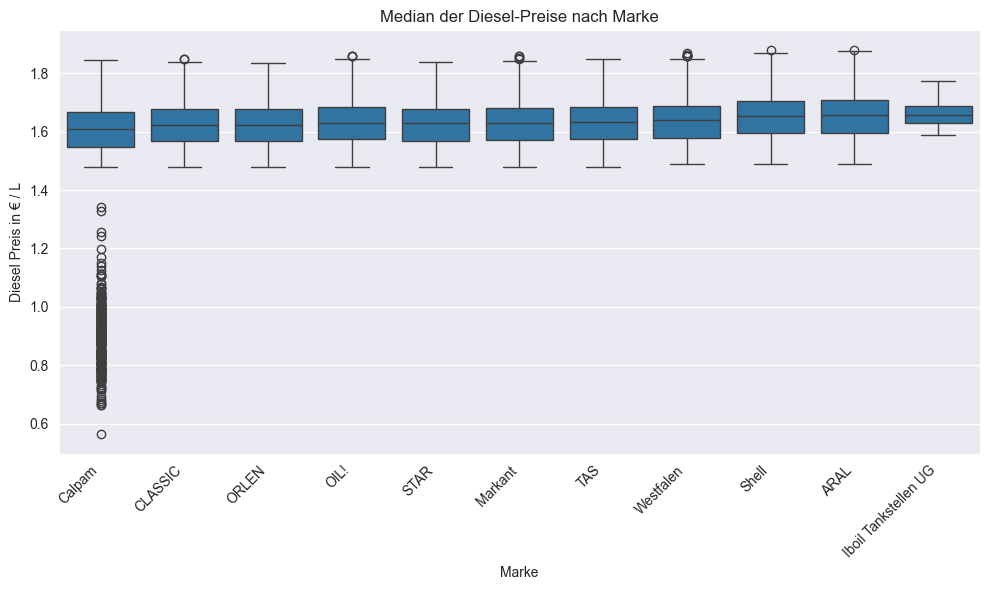

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='brand', y='diesel', order=df.groupby('brand')['diesel'].median().sort_values().index)

plt.title('Median der Diesel-Preise nach Marke')
plt.xlabel('Marke')
plt.ylabel('Diesel Preis in € / L')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Betrachtung mit Ausreißerbereinigung

Ausschließen der Ausreißer

In [82]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_clean = df.copy()
for col in ['e5', 'e10', 'diesel']:
    df_clean = remove_outliers_iqr(df_clean, col)
print(f'Ursprüngliche Form: {df.shape}')
print(f'Bereinigte Form:   {df_clean.shape}')
df = df_clean
df = df.drop(['Unnamed: 0'], axis=1)

Ursprüngliche Form: (73589, 23)
Bereinigte Form:   (73096, 23)


## Kraftstoff vs. Zeit

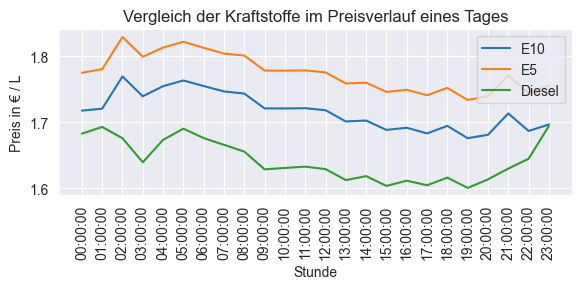

In [83]:
plt.figure(figsize=(6, 3))

sns.lineplot(x='hour', y='e10', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E10')
sns.lineplot(x='hour', y='e5', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E5')
sns.lineplot(x='hour', y='diesel', data=(df.groupby('hour', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='Diesel')

plt.title('Vergleich der Kraftstoffe im Preisverlauf eines Tages')
plt.xlabel('Stunde')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

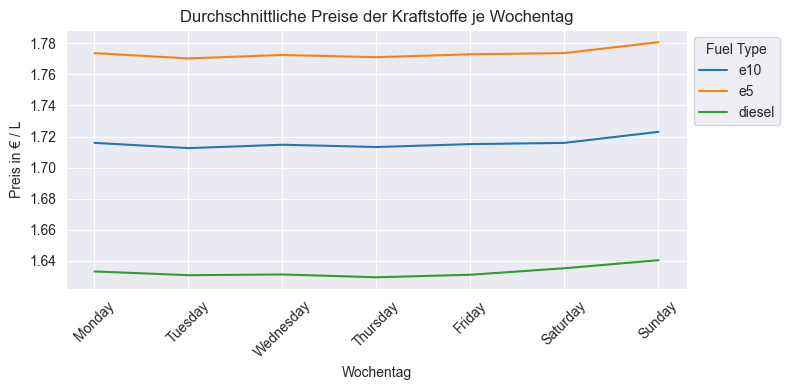

In [84]:
weekday_avg = df.groupby('weekday', observed=False)[['e10', 'e5', 'diesel']].mean().reset_index()
weekday_long = weekday_avg.melt(id_vars='weekday', value_vars=['e10', 'e5', 'diesel'], var_name='Fuel', value_name='Price')
weekday_long['weekday'] = pd.Categorical(weekday_long['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

plt.figure(figsize=(8, 4))
#sns.barplot(data=weekday_long, x='weekday', y='Price', hue='Fuel')
sns.lineplot(data=weekday_long, x='weekday', y='Price', hue='Fuel')
plt.title('Durchschnittliche Preise der Kraftstoffe je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=45)
plt.legend(title='Fuel Type', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

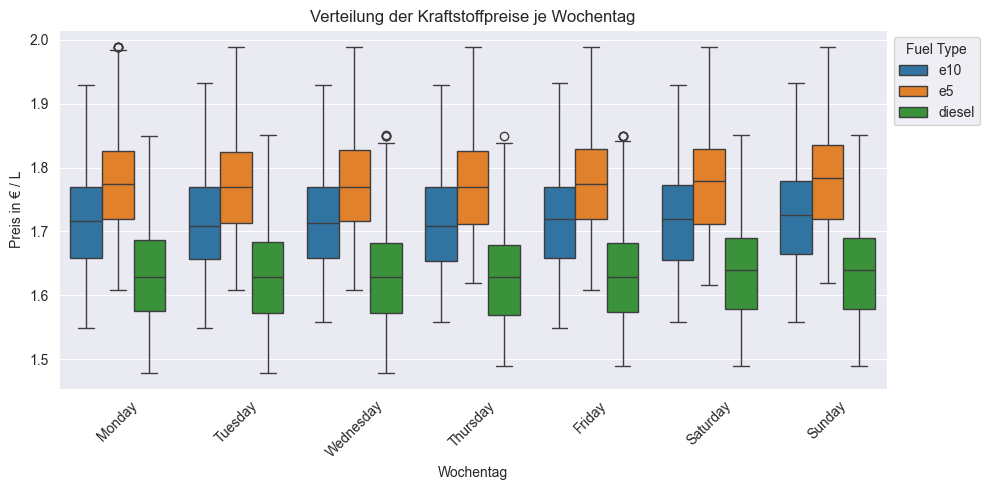

In [85]:
weekday_long = df.melt(id_vars='weekday',value_vars=['e10', 'e5', 'diesel'],var_name='Fuel',value_name='Price')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_long['weekday'] = pd.Categorical(weekday_long['weekday'], categories=weekday_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.boxplot(data=weekday_long, x='weekday', y='Price', hue='Fuel')
plt.title('Verteilung der Kraftstoffpreise je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Preis in € / L')
plt.xticks(rotation=45)
plt.legend(title='Fuel Type', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

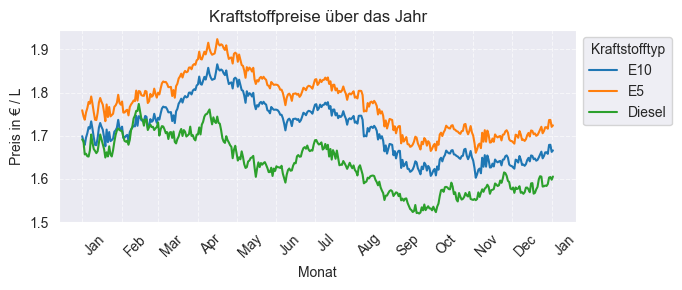

In [86]:
plt.figure(figsize=(6, 3))

sns.lineplot(x='date', y='e10', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E10')
sns.lineplot(x='date', y='e5', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='E5')
sns.lineplot(x='date', y='diesel', data=(df.groupby('date', observed=False)[['e10', 'diesel', 'e5']].mean().reset_index()), label='Diesel')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45, ha='left')
plt.title('Kraftstoffpreise über das Jahr')
plt.xlabel('Monat')
plt.ylabel('Preis in € / L')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Kraftstofftyp', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

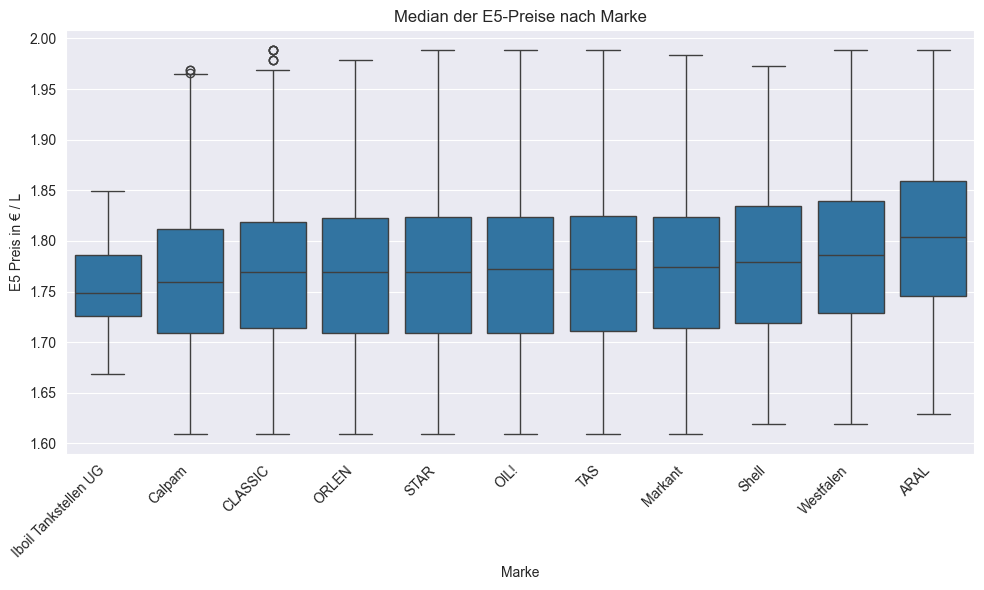

In [87]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='brand', y='e5', order=df.groupby('brand')['e5'].median().sort_values().index)

plt.title('Median der E5-Preise nach Marke')
plt.xlabel('Marke')
plt.ylabel('E5 Preis in € / L')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preis nach Anbieter Ort und Zeit (check)

### Marke, Stunde, Preis

/var/folders/_9/fyqnr96j0q7_tlytmj22wy8c0000gn/T/ipykernel_83834/4075768116.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour


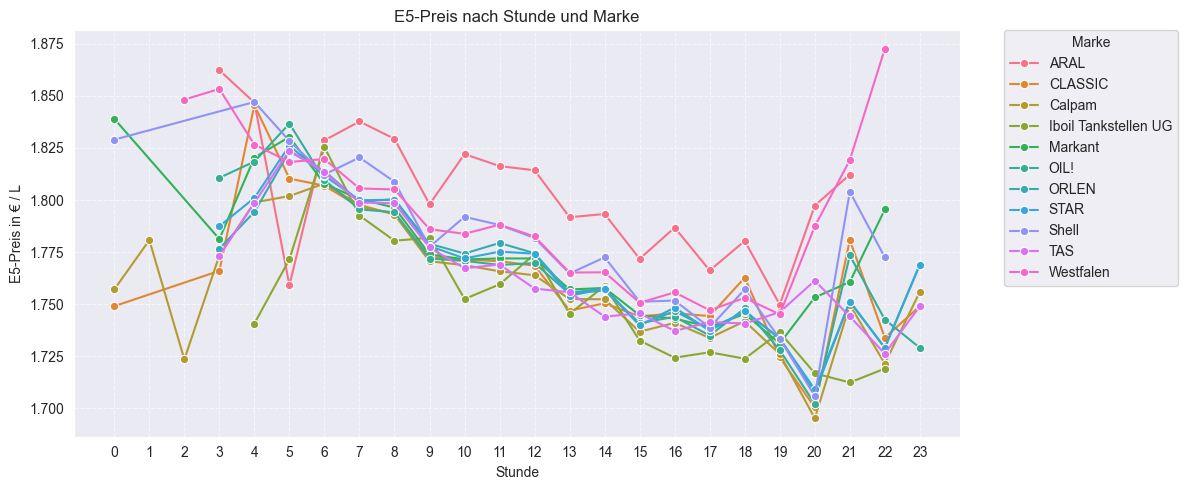

In [88]:
hourly_prices = df.groupby(['brand', 'hour'], observed=False)['e5'].mean().reset_index()
hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour

plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_prices, x='hour', y='e5', hue='brand', marker='o', errorbar=None)

plt.title('E5-Preis nach Stunde und Marke')
plt.xlabel('Stunde')
plt.ylabel('E5-Preis in € / L')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Marke', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Die Linien zeigen die durchschnittlichen E5-Preise pro Stunde, gruppiert nach Tankstellenmarke.
- Leichter Rückgang tagsüber und Anstieg am Abend.
- Calpam zeigt ungewöhnlich niedrige Preise zwischen 0 und 3 Uhr und einen plötzlichen Anstieg ab 4 Uhr. Dies deutet auf  fehlerhafte Messwerte hin.

/var/folders/_9/fyqnr96j0q7_tlytmj22wy8c0000gn/T/ipykernel_83834/3613140240.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour


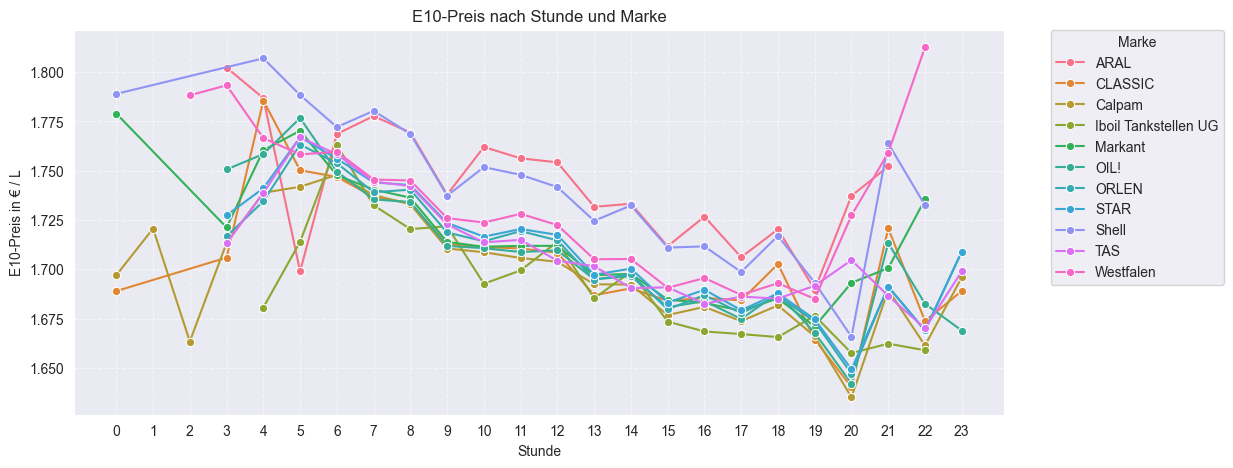

In [89]:
hourly_prices = df.groupby(['brand', 'hour'], observed=False)['e10'].mean().reset_index()
hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour

plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_prices, x='hour', y='e10', hue='brand', marker='o', errorbar=None)

plt.title('E10-Preis nach Stunde und Marke')
plt.xlabel('Stunde')
plt.ylabel('E10-Preis in € / L')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Marke', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Auffälligkeiten:
- Die E10-Preise zeigen ein ähnliches Muster wie E5, mit tageszeitlicher Abnahme.
- Marken wie ARAL, Shell, Westfalen liegen im oberen Preisbereich.
- Wieder fällt Calpam durch extrem niedrige Preise nachts auf.

/var/folders/_9/fyqnr96j0q7_tlytmj22wy8c0000gn/T/ipykernel_83834/485453661.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour


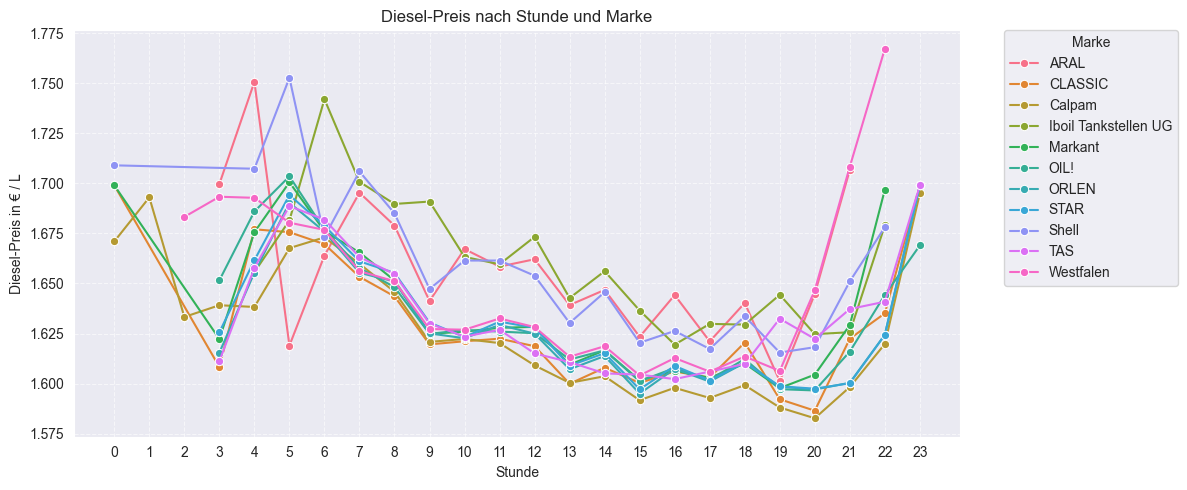

In [90]:
hourly_prices = df.groupby(['brand', 'hour'], observed=False)['diesel'].mean().reset_index()
hourly_prices['hour'] = pd.to_datetime(hourly_prices['hour']).dt.hour

plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_prices, x='hour', y='diesel', hue='brand', marker='o', errorbar=None)

plt.title('Diesel-Preis nach Stunde und Marke')
plt.xlabel('Stunde')
plt.ylabel('Diesel-Preis in € / L')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Marke', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Nachts vor allem stabile Preise, ein Minimum am Nachmittag und steigende Preise ab ca. 20 Uhr.
- Auch hier ist Calpam ein Ausreißer mit unrealistisch tiefen Werten nachts.
- Westfalen, ARAL, Shell sind im oberen Preisbereich konstant.

## Saisonidentifizierung

### Saisonalität innerhalb einer Woche

<Figure size 1000x800 with 0 Axes>

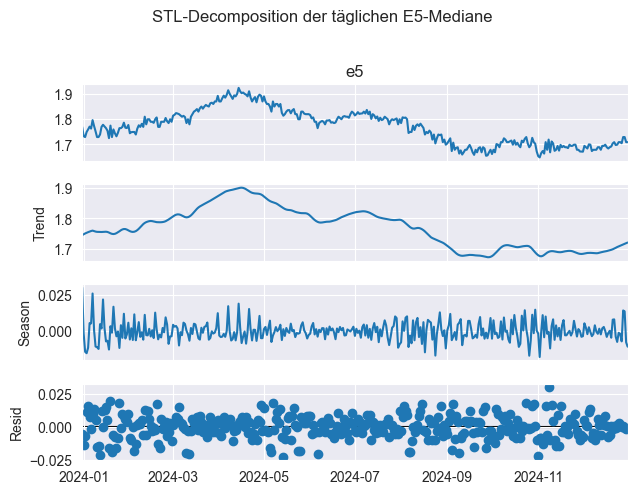

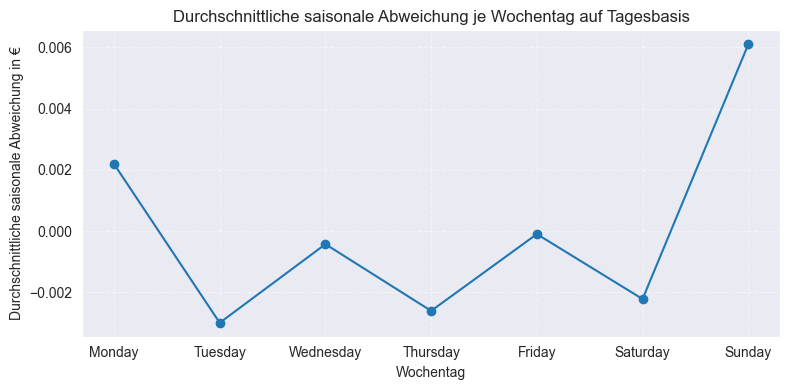

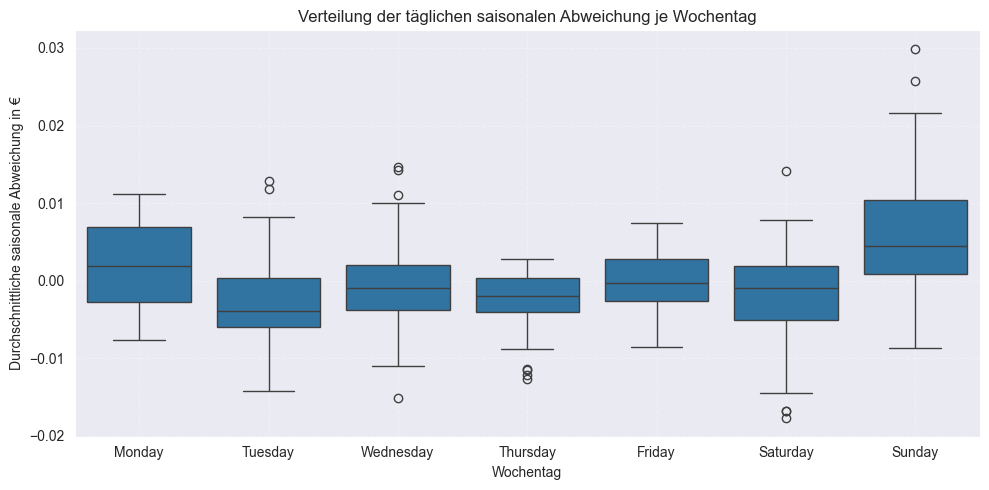

In [91]:
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')
e5_medianByDay = (df_sorted.groupby('date', observed=False)['e5'].median().reset_index())
e5_medianByDay['date'] = pd.to_datetime(e5_medianByDay['date'])
e5_medianByDay.set_index('date', inplace=True)
e5_series = e5_medianByDay['e5'].asfreq('D')

stl = STL(e5_series, period=7, seasonal=7)
result = stl.fit()

plt.figure(figsize=(10, 8))
result.plot()
plt.suptitle('STL-Decomposition der täglichen E5-Mediane', y=1.02)
plt.tight_layout()
plt.show()

# Saisonale Komponenten identifizieren
seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['weekday'] = seasonal_df['date'].dt.day_name()

# Sortierung der Wochentag
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
seasonal_df['weekday'] = pd.Categorical(seasonal_df['weekday'], categories=ordered_days, ordered=True)

weekday_mean = seasonal_df.groupby('weekday', observed=False)['seasonal'].mean()

plt.figure(figsize=(8, 4))
weekday_mean.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung je Wochentag auf Tagesbasis')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='weekday', y='seasonal')
plt.title('Verteilung der täglichen saisonalen Abweichung je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Wochentag zu den Originaldaten hinzufügen
e5_medianByDay = e5_medianByDay.reset_index()
e5_medianByDay['weekday'] = e5_medianByDay['date'].dt.day_name()
e5_medianByDay['weekday'] = pd.Categorical(e5_medianByDay['weekday'], categories=ordered_days, ordered=True)

Auffälligkeiten:
- Hier wird der Trend der Woche ausgeschlossen.
- Es können saisonale Effekte über die Woche hinweg erkannt werden.
    - Am Dienstag ist das Wochenminimum, am Mittwoch steigt der Preis wieder, um dann am Donnerstag erneut zu sinken.
    - Das Maximum der Woche ist am Sonntag.
- Im Vergleich zu der ursprünglichen Verteilung kann man klar einen saisonalen Effekt erkennen.
- Innerhalb der Woche liegt der preisliche Unterschiede bei 0,008 €

<Figure size 1000x800 with 0 Axes>

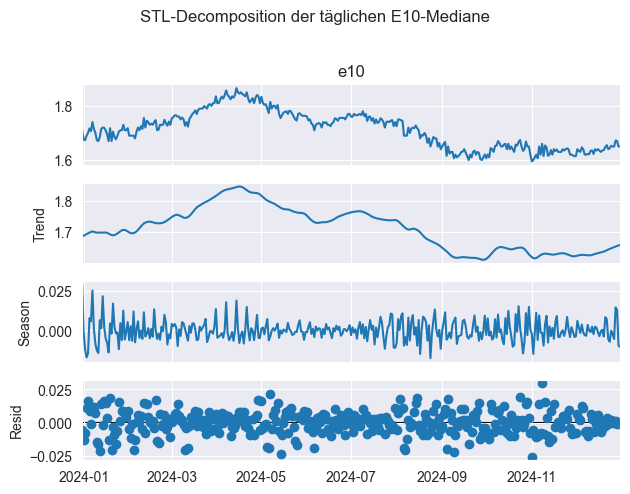

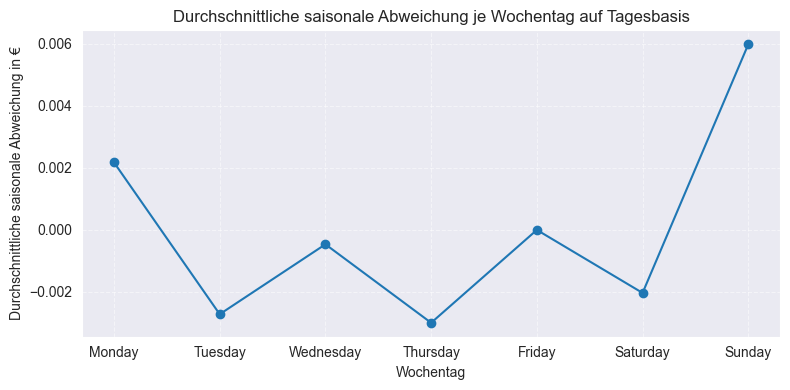

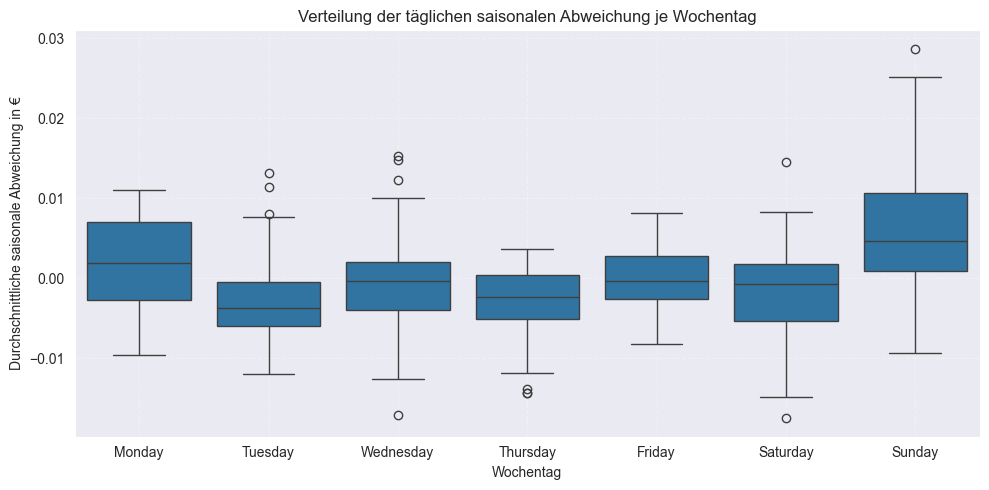

In [92]:
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')
e10_medianByDay = (df_sorted.groupby('date', observed=False)['e10'].median().reset_index())
e10_medianByDay['date'] = pd.to_datetime(e10_medianByDay['date'])
e10_medianByDay.set_index('date', inplace=True)
e10_series = e10_medianByDay['e10'].asfreq('D')

stl = STL(e10_series, period=7, seasonal=7)
result = stl.fit()

plt.figure(figsize=(10, 8))
result.plot()
plt.suptitle('STL-Decomposition der täglichen E10-Mediane', y=1.02)
plt.tight_layout()
plt.show()

# Saisonale Komponenten identifizieren
seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['weekday'] = seasonal_df['date'].dt.day_name()

# Sortierung der Wochentag
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
seasonal_df['weekday'] = pd.Categorical(seasonal_df['weekday'], categories=ordered_days, ordered=True)

weekday_mean = seasonal_df.groupby('weekday', observed=False)['seasonal'].mean()

plt.figure(figsize=(8, 4))
weekday_mean.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung je Wochentag auf Tagesbasis')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='weekday', y='seasonal')
plt.title('Verteilung der täglichen saisonalen Abweichung je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Wochentag zu den Originaldaten hinzufügen
e10_medianByDay = e10_medianByDay.reset_index()
e10_medianByDay['weekday'] = e10_medianByDay['date'].dt.day_name()
e10_medianByDay['weekday'] = pd.Categorical(e10_medianByDay['weekday'], categories=ordered_days, ordered=True)

Auffälligkeiten:
- Hier kann man einen sehr ähnlichen Effekt erkennen, wie bei dem Kraftstoff E5.
- Der Unterschied liegt darin, dass das Minimum der Woche am Donnerstag ist und nicht am Dienstag.
- Innerhalb der Woche liegt der preisliche Unterschiede bei 0,008 €

<Figure size 1000x800 with 0 Axes>

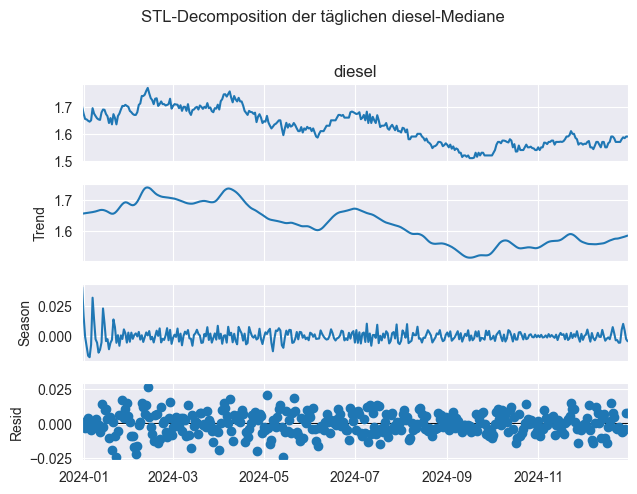

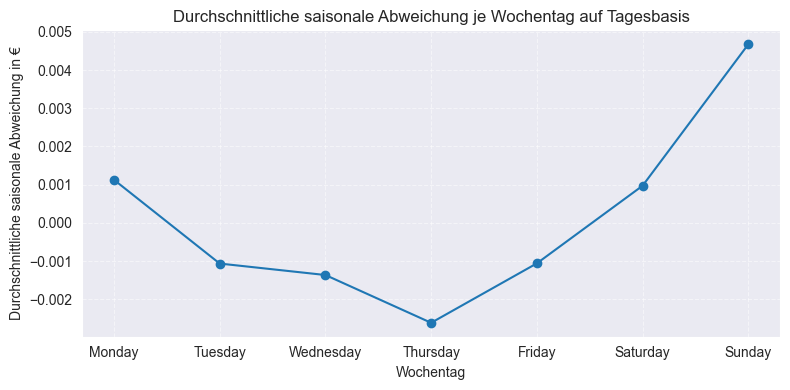

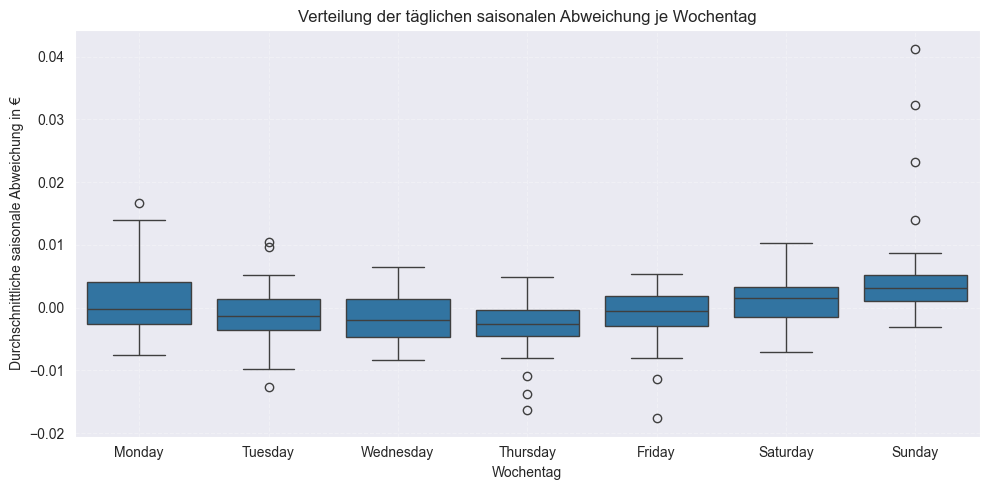

In [93]:
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')
diesel_medianByDay = (df_sorted.groupby('date', observed=False)['diesel'].median().reset_index())
diesel_medianByDay['date'] = pd.to_datetime(diesel_medianByDay['date'])
diesel_medianByDay.set_index('date', inplace=True)
diesel_series = diesel_medianByDay['diesel'].asfreq('D')

stl = STL(diesel_series, period=7, seasonal=7)
result = stl.fit()

plt.figure(figsize=(10, 8))
result.plot()
plt.suptitle('STL-Decomposition der täglichen diesel-Mediane', y=1.02)
plt.tight_layout()
plt.show()

seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['weekday'] = seasonal_df['date'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
seasonal_df['weekday'] = pd.Categorical(seasonal_df['weekday'], categories=ordered_days, ordered=True)

weekday_mean = seasonal_df.groupby('weekday', observed=False)['seasonal'].mean()

plt.figure(figsize=(8, 4))
weekday_mean.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung je Wochentag auf Tagesbasis')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='weekday', y='seasonal')
plt.title('Verteilung der täglichen saisonalen Abweichung je Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Durchschnittliche saisonale Abweichung in €')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Wochentag zu den Originaldaten hinzufügen
diesel_medianByDay = diesel_medianByDay.reset_index()
diesel_medianByDay['weekday'] = diesel_medianByDay['date'].dt.day_name()
diesel_medianByDay['weekday'] = pd.Categorical(diesel_medianByDay['weekday'], categories=ordered_days, ordered=True)

Auffälligkeiten:
- Hierbei ist eine andere Verteilung zu erkennen, im Vergleich zu den anderen Kraftstoffen:
- Am Anfang der Woche fallen die Preise, bis zum Donnerstag, an dem das Minimum erreicht wird.
- Von Donnerstag bis Sonntag steigen wieder die Preise.
- Auffällig ist, dass die Ausreißer am Sonntag mehr und verteilter sind.
- Innerhalb der Woche liegt der preisliche Unterschiede bei 0,007 €

### Saisonalität auf Tagesebene

<Figure size 1200x800 with 0 Axes>

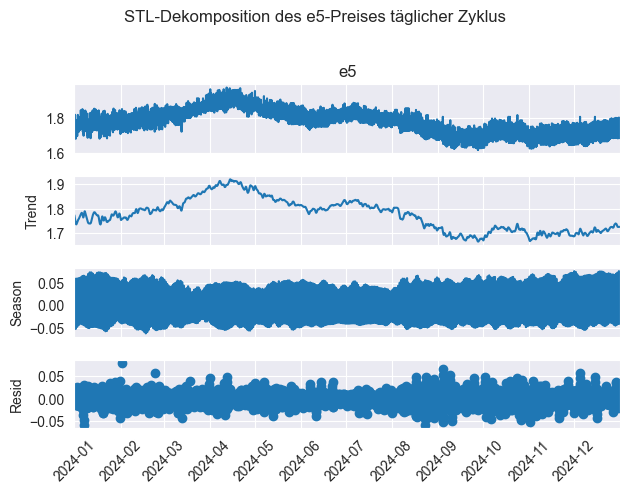

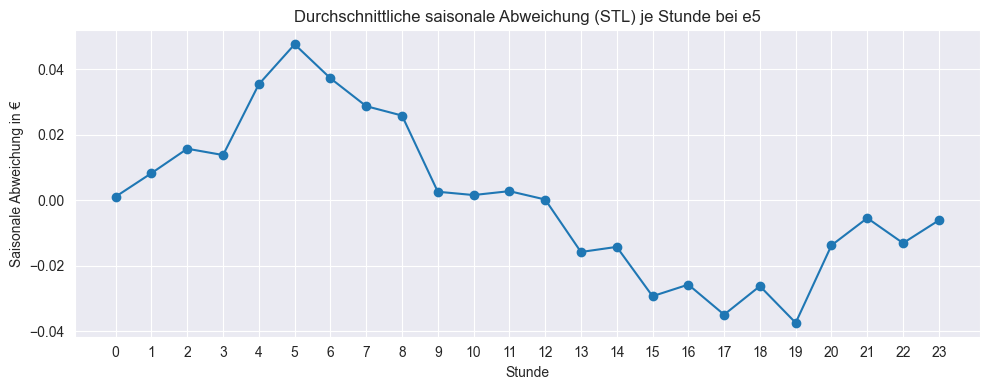

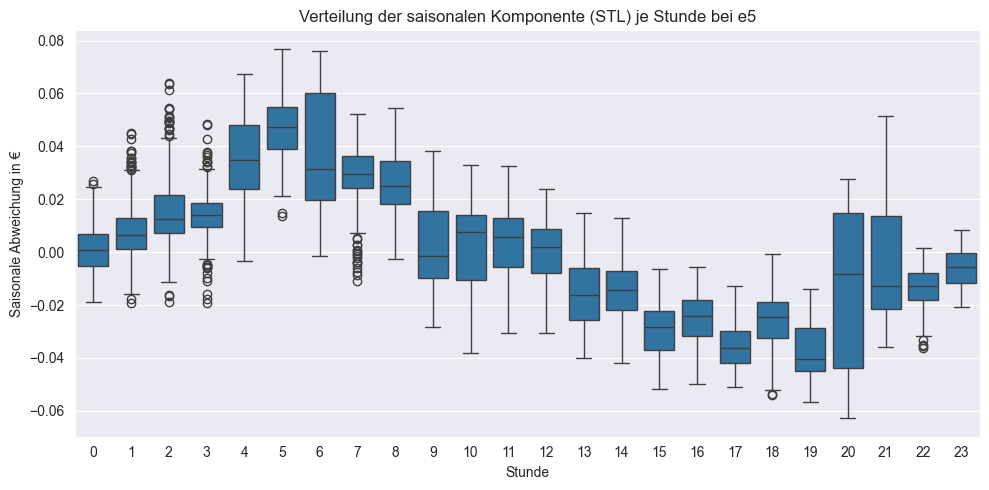

In [94]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str))
df_sorted = df.sort_values('datetime')
e5_series = df_sorted.groupby('datetime', observed=False)['e5'].mean()
e5_series = e5_series.asfreq('h')
e5_series = e5_series.interpolate(method='time')

stl = STL(e5_series, period=24)
result = stl.fit()

plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('STL-Dekomposition des e5-Preises täglicher Zyklus', y=1.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saison ermitteln
seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['hour'] = seasonal_df['datetime'].dt.hour

# Vergleichsdaten
original_df = e5_series.reset_index(name='e5')
original_df['hour'] = original_df['datetime'].dt.hour

mean_seasonal = seasonal_df.groupby('hour')['seasonal'].mean()

plt.figure(figsize=(10, 4))
mean_seasonal.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung (STL) je Stunde bei e5')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='hour', y='seasonal')
plt.title('Verteilung der saisonalen Komponente (STL) je Stunde bei e5')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Auch bei der Betrachtung der Tage ist zu erkennen, dass es eine Saison über Tag gibt.
- Ein Preis-Peak ist ein Preisspitzenwert um 5 Uhr morgens, danach fallen die Preise wieder bis 19 Uhr, dann steigen die Preise wieder.
- Um 20 Uhr ist die Differenz zwischen den Quartilen am größten.
- Innerhalb eines Tages liegt der Unterschied bei 0,1 €

<Figure size 1200x800 with 0 Axes>

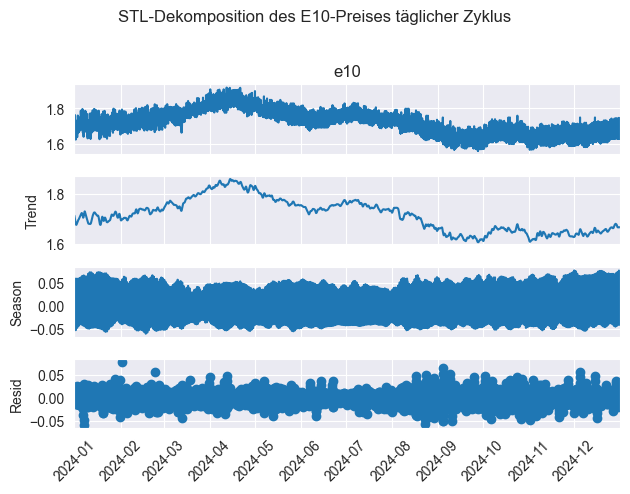

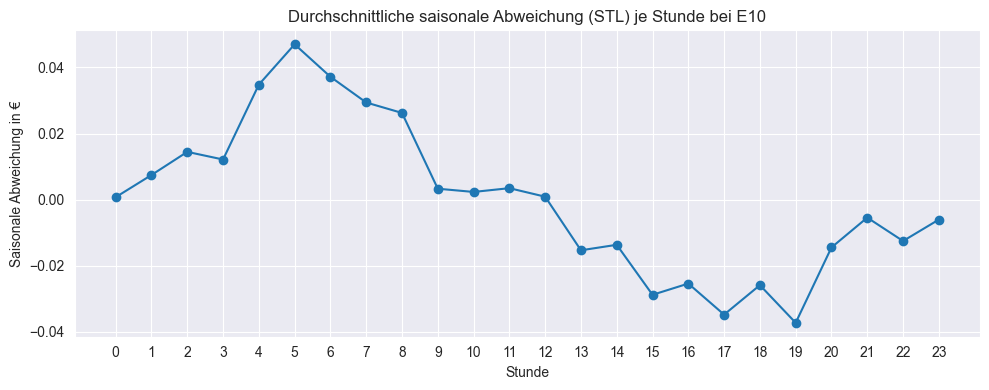

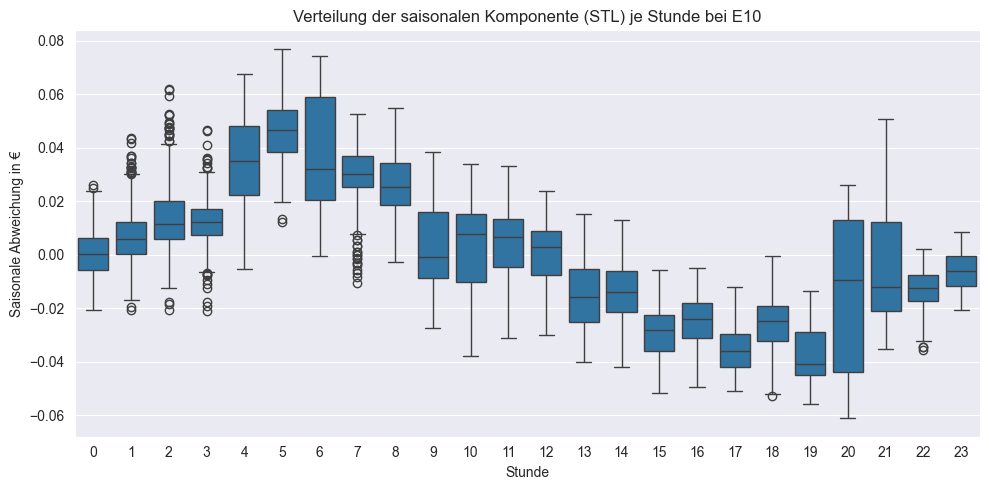

In [95]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str))
df_sorted = df.sort_values('datetime')
e10_series = df_sorted.groupby('datetime', observed=False)['e10'].mean()
e10_series = e10_series.asfreq('h')
e10_series = e10_series.interpolate(method='time')

stl = STL(e10_series, period=24)
result = stl.fit()

plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('STL-Dekomposition des E10-Preises täglicher Zyklus', y=1.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saison ermitteln
seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['hour'] = seasonal_df['datetime'].dt.hour

# Vergleichsdaten
original_df = e10_series.reset_index(name='e10')
original_df['hour'] = original_df['datetime'].dt.hour

mean_seasonal = seasonal_df.groupby('hour')['seasonal'].mean()

plt.figure(figsize=(10, 4))
mean_seasonal.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung (STL) je Stunde bei E10')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='hour', y='seasonal')
plt.title('Verteilung der saisonalen Komponente (STL) je Stunde bei E10')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.tight_layout()
plt.show()


Auffälligkeiten:
- Ähnliche Verteilung wie bei dem Kraftstoff E5.
- Innerhalb eines Tages liegt der Unterschied bei 0,1 €

<Figure size 1200x800 with 0 Axes>

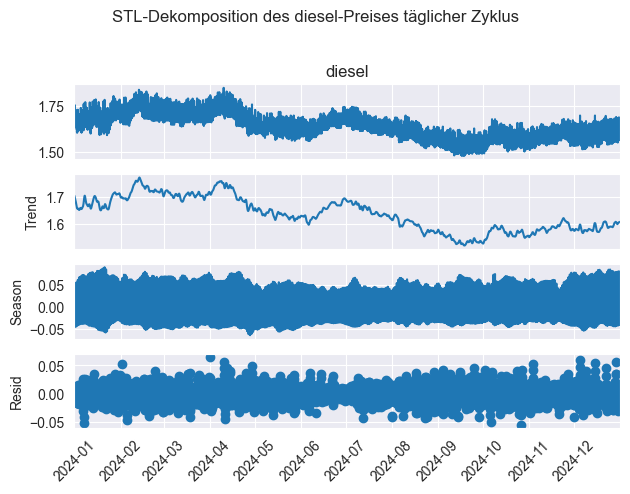

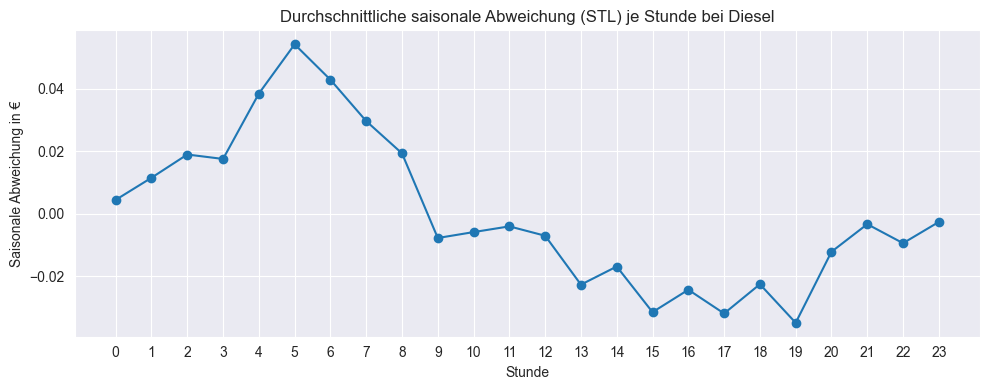

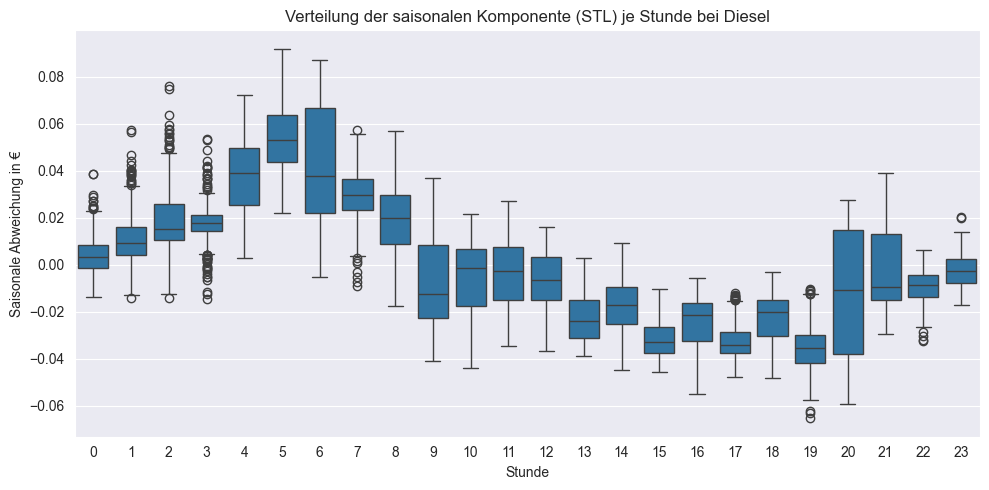

In [96]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str))
df_sorted = df.sort_values('datetime')
diesel_series = df_sorted.groupby('datetime', observed=False)['diesel'].mean()
diesel_series = diesel_series.asfreq('h')
diesel_series = diesel_series.interpolate(method='time')

stl = STL(diesel_series, period=24)
result = stl.fit()

plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('STL-Dekomposition des diesel-Preises täglicher Zyklus', y=1.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saison ermitteln
seasonal_df = result.seasonal.reset_index(name='seasonal')
seasonal_df['hour'] = seasonal_df['datetime'].dt.hour

# Vergleichsdaten
original_df = diesel_series.reset_index(name='diesel')
original_df['hour'] = original_df['datetime'].dt.hour

mean_seasonal = seasonal_df.groupby('hour')['seasonal'].mean()

plt.figure(figsize=(10, 4))
mean_seasonal.plot(marker='o')
plt.title('Durchschnittliche saisonale Abweichung (STL) je Stunde bei Diesel')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=seasonal_df, x='hour', y='seasonal')
plt.title('Verteilung der saisonalen Komponente (STL) je Stunde bei Diesel')
plt.xlabel('Stunde')
plt.ylabel('Saisonale Abweichung in €')
plt.tight_layout()
plt.show()

Auffälligkeiten:
- Auch beim Diesel ist das Maximum ebenfalls um 5 Uhr.
- Danach sinken die Preise bis 9 Uhr stark.
- Zwischen 9 und 12 Uhr steigen die Preise wieder leicht.
- Ab 12 bis 19 Uhr schwanken die Preise, um dann um 19 Uhr den Tiefpunkt zu erreichen.
- Danach steigen die Preise wieder.
- Innerhalb eines Tages liegt der Unterschied bei 0,07 €

## Auffälligkeiten:
Bei dieser Analyse wurde die Frage, wann und wo am besten getankt werden kann, innerhalb des betrachteten geografischen Ausschnitts. Auch nach Bereinigung der Trends ist zu erkennen, dass der Preis für E5 am Dienstag und für E10 und Diesel am Donnerstag am niedrigsten ist. Bei allen Kraftstoffen ist der Preis gegen 19 Uhr am günstigsten. Zu dieser Uhrzeit ist Calpam die günstigste Tankstelle. Allerdings sollte vor dem Tanken geprüft werden, ob die Preise noch zutreffen, da es bei Calpam auch zu extremen Ausreißern nach unten gekommen ist, die auf eine fehlerhafte Datenübertragung hindeuten. Für eine genaue Überprüfung werden die Saisonalitäten der Tankstellen seperat betrachtet, sodass die beste Zeit je Tankstelle betrachtet werden kann:

In [97]:
print("Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle")
station_specific_bests = []
global_min_price = float('inf')
global_min_station_info = None
day_mapping = {
    0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}

for station_id in df['station_uuid'].unique():
    df_station = df[df['station_uuid'] == station_id].copy()
    datetime_str = df_station['date'].astype(str) + ' ' + df_station['hour'].astype(str)
    df_station['datetime'] = pd.to_datetime(datetime_str)
    df_station = df_station.drop_duplicates(subset=['datetime']).sort_values('datetime')
    e5_series = df_station.set_index('datetime')['e5'].asfreq('h').interpolate(method='time')
    if len(e5_series.dropna()) >= 2 * 168:
        try:
            stl = STL(e5_series.dropna(), period=168, robust=True).fit()
        except ValueError as e:
            print(f"STL-Analyse für Station {station_id} übersprungen: {e}")
            continue

        station_best_time_idx = stl.seasonal.idxmin()
        station_min_seasonal_val = stl.seasonal.min()
        station_specific_bests.append({
            "Tankstelle": station_id,
            "Bester Tag": day_mapping[station_best_time_idx.dayofweek],
            "Beste Stunde": station_best_time_idx.hour,
            "Max. Preisabfall (relativ)": station_min_seasonal_val})

if station_specific_bests:
    df_specific_bests = pd.DataFrame(station_specific_bests)
    df_specific_bests_display = df_specific_bests.copy()
    df_specific_bests_display['Max. Preisabfall (relativ)'] = df_specific_bests_display['Max. Preisabfall (relativ)'].map('{:.4f}'.format)
    print(df_specific_bests_display.to_string(index=False))

print('Die günstigste Tankstelle bezogen auf den Durchschnittspreis')
average_prices = df.groupby('station_uuid')['e5'].mean().reset_index()
average_prices.columns = ['Tankstelle', 'Durchschnittspreis']
two_cheapest_stations = average_prices.sort_values(by='Durchschnittspreis').head(2)
two_cheapest_stations['Durchschnittspreis'] = two_cheapest_stations['Durchschnittspreis'].map('{:.3f} €'.format)
print(two_cheapest_stations.to_string(index=False))


Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle
                          Tankstelle Bester Tag  Beste Stunde Max. Preisabfall (relativ)
005056ba-7cb6-1ed2-bceb-519b93268d12   Dienstag            20                    -0.0701
005056ba-7cb6-1ed2-bceb-568a4bb56d15   Dienstag            20                    -0.0750
005056ba-7cb6-1ed2-bceb-842a27f12d2e   Dienstag            20                    -0.0695
22c0f242-2209-4b43-b544-26e2b5a2463c Donnerstag            20                    -0.0936
2966f3e3-e45f-4439-ba49-1c0c481f5f3d Donnerstag            17                    -0.1273
2dbf6b64-a83d-4630-ad83-c16015b8efa4   Mittwoch            21                    -0.0737
4c746120-5b7d-40ca-8c75-ccd55c4d0814 Donnerstag            20                    -0.0948
831a250e-5810-4bee-bf20-8acd0b60d205 Donnerstag            20                    -0.1068
bad559b9-cabe-4589-bafb-5547683b6562 Donnerstag            20                    -0.0805
c8e68ec5-8eac-11e9-83b5-005056a2a083 Donners

Neben den Saisonalitäten je Tankstelle werden zusätzlich die beiden günstigsten Tankstellen über das Jahr hinweg ausgegeben. Das hat den Zweck, dass die günstigste Tankstelle angezeigt werden soll und dann verglichen werden kann, zu welchem Zeitpunkt an dieser Tankstelle getankt werden kann. Die günstigste Tankstelle ist in der oberen Tabelle nicht vorhanden, da diese den Qualitätscheck nicht besteht. Dieser Qualitätscheck prüft, ob ausreichend Daten vorliegen, um die Saisonalität zu ermitteln. Die günstigste Tankstelle hier ist die Tankstelle mit der ID: 2dbf6b64-a83d-4630-ad83-c16015b8efa4. Aus der oberen Tabelle ist zu sehen, dass man hier am Mittwoch um 21 Uhr tanken sollte.

In [98]:
print("Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle")
station_specific_bests = []
global_min_price = float('inf')
global_min_station_info = None
day_mapping = {
    0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}

for station_id in df['station_uuid'].unique():
    df_station = df[df['station_uuid'] == station_id].copy()
    datetime_str = df_station['date'].astype(str) + ' ' + df_station['hour'].astype(str)
    df_station['datetime'] = pd.to_datetime(datetime_str)
    df_station = df_station.drop_duplicates(subset=['datetime']).sort_values('datetime')
    e10_series = df_station.set_index('datetime')['e10'].asfreq('h').interpolate(method='time')
    if len(e10_series.dropna()) >= 2 * 168:
        try:
            stl = STL(e10_series.dropna(), period=168, robust=True).fit()
        except ValueError as e:
            print(f"STL-Analyse für Station {station_id} übersprungen: {e}")
            continue

        station_best_time_idx = stl.seasonal.idxmin()
        station_min_seasonal_val = stl.seasonal.min()
        station_specific_bests.append({
            "Tankstelle": station_id,
            "Bester Tag": day_mapping[station_best_time_idx.dayofweek],
            "Beste Stunde": station_best_time_idx.hour,
            "Max. Preisabfall (relativ)": station_min_seasonal_val})

if station_specific_bests:
    df_specific_bests = pd.DataFrame(station_specific_bests)
    df_specific_bests_display = df_specific_bests.copy()
    df_specific_bests_display['Max. Preisabfall (relativ)'] = df_specific_bests_display['Max. Preisabfall (relativ)'].map('{:.4f}'.format)
    print(df_specific_bests_display.to_string(index=False))

print('Die günstigste Tankstelle bezogen auf den Durchschnittspreis')
average_prices = df.groupby('station_uuid')['e10'].mean().reset_index()
average_prices.columns = ['Tankstelle', 'Durchschnittspreis']
two_cheapest_stations = average_prices.sort_values(by='Durchschnittspreis').head(2)
two_cheapest_stations['Durchschnittspreis'] = two_cheapest_stations['Durchschnittspreis'].map('{:.3f} €'.format)
print(two_cheapest_stations.to_string(index=False))

Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle
                          Tankstelle Bester Tag  Beste Stunde Max. Preisabfall (relativ)
005056ba-7cb6-1ed2-bceb-519b93268d12   Dienstag            15                    -0.0724
005056ba-7cb6-1ed2-bceb-568a4bb56d15   Dienstag            20                    -0.0747
005056ba-7cb6-1ed2-bceb-842a27f12d2e   Dienstag            20                    -0.0694
22c0f242-2209-4b43-b544-26e2b5a2463c Donnerstag            20                    -0.0936
2966f3e3-e45f-4439-ba49-1c0c481f5f3d Donnerstag            17                    -0.1273
2dbf6b64-a83d-4630-ad83-c16015b8efa4   Mittwoch            21                    -0.0749
4c746120-5b7d-40ca-8c75-ccd55c4d0814 Donnerstag            20                    -0.0948
831a250e-5810-4bee-bf20-8acd0b60d205 Donnerstag            20                    -0.1069
bad559b9-cabe-4589-bafb-5547683b6562     Montag            18                    -0.0719
c8e68ec5-8eac-11e9-83b5-005056a2a083 Donners

Auch bei E10 wurde die günstigste Tankstelle im Qualitätscheck ausgeschlossen. Auch hier ist die günstigste Tankstelle die mit der ID: 2dbf6b64-a83d-4630-ad83-c16015b8efa4. Am günstigsten ist die Tankstelle am Mittwoch um 21 Uhr.

In [99]:
print("Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle")
station_specific_bests = []
global_min_price = float('inf')
global_min_station_info = None
day_mapping = {
    0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}

for station_id in df['station_uuid'].unique():
    df_station = df[df['station_uuid'] == station_id].copy()
    datetime_str = df_station['date'].astype(str) + ' ' + df_station['hour'].astype(str)
    df_station['datetime'] = pd.to_datetime(datetime_str)
    df_station = df_station.drop_duplicates(subset=['datetime']).sort_values('datetime')
    diesel_series = df_station.set_index('datetime')['diesel'].asfreq('h').interpolate(method='time')
    if len(diesel_series.dropna()) >= 2 * 168:
        try:
            stl = STL(diesel_series.dropna(), period=168, robust=True).fit()
        except ValueError as e:
            print(f"STL-Analyse für Station {station_id} übersprungen: {e}")
            continue

        station_best_time_idx = stl.seasonal.idxmin()
        station_min_seasonal_val = stl.seasonal.min()
        station_specific_bests.append({
            "Tankstelle": station_id,
            "Bester Tag": day_mapping[station_best_time_idx.dayofweek],
            "Beste Stunde": station_best_time_idx.hour,
            "Max. Preisabfall (relativ)": station_min_seasonal_val})

if station_specific_bests:
    df_specific_bests = pd.DataFrame(station_specific_bests)
    df_specific_bests_display = df_specific_bests.copy()
    df_specific_bests_display['Max. Preisabfall (relativ)'] = df_specific_bests_display['Max. Preisabfall (relativ)'].map('{:.4f}'.format)
    print(df_specific_bests_display.to_string(index=False))

print('Die günstigste Tankstelle bezogen auf den Durchschnittspreis')
average_prices = df.groupby('station_uuid')['diesel'].mean().reset_index()
average_prices.columns = ['Tankstelle', 'Durchschnittspreis']
two_cheapest_stations = average_prices.sort_values(by='Durchschnittspreis').head(2)
two_cheapest_stations['Durchschnittspreis'] = two_cheapest_stations['Durchschnittspreis'].map('{:.3f} €'.format)
print(two_cheapest_stations.to_string(index=False))

Ausgabe der saisonalen Preisabfällen in einer Woche je Tankstelle
                          Tankstelle Bester Tag  Beste Stunde Max. Preisabfall (relativ)
005056ba-7cb6-1ed2-bceb-519b93268d12 Donnerstag            20                    -0.0804
005056ba-7cb6-1ed2-bceb-568a4bb56d15 Donnerstag            22                    -0.0625
005056ba-7cb6-1ed2-bceb-842a27f12d2e Donnerstag            20                    -0.0821
22c0f242-2209-4b43-b544-26e2b5a2463c Donnerstag            20                    -0.0758
2966f3e3-e45f-4439-ba49-1c0c481f5f3d Donnerstag            20                    -0.1239
2dbf6b64-a83d-4630-ad83-c16015b8efa4    Freitag            21                    -0.0556
4c746120-5b7d-40ca-8c75-ccd55c4d0814 Donnerstag            20                    -0.0962
831a250e-5810-4bee-bf20-8acd0b60d205   Dienstag            15                    -0.0851
bad559b9-cabe-4589-bafb-5547683b6562   Dienstag            13                    -0.0582
c8e68ec5-8eac-11e9-83b5-005056a2a083 Donners

Bei der Betrachtung des Diesel ist zu erkennen, dass erneut die Tankstelle mit der ID: 2dbf6b64-a83d-4630-ad83-c16015b8efa4 am günstigsten ist. Die Tankstelle ist am günstigsten am Freitag um 21 Uhr.